# **Klasifikasi Buah Segar dan Busuk Menggunakan Pemrosesan Citra Warna dan Ekstraksi Ciri Warna** #

# **Import Library**

In [ ]:

import cv2
import numpy as np
import numba
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tabulate import tabulate
import os
import glob
import itertools


# **Deskripsi Data**

Dataset yang digunakan dalam proyek ini terdiri dari gambar buah-buahan yang dikategorikan berdasarkan tingkat kematangannya: segar (fresh) atau busuk (rotten). Data ini mencakup tiga jenis buah—pisang (banana), apel (apple), dan jeruk (orange). Setiap kategori berisi gambar dengan format JPG atau PNG.

- Jenis data: Data citra (format RGB), yang kemudian dikonversi ke HSV untuk ekstraksi fitur berbasis warna.

- Sumber data: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
- Jumlah data: 3000 gambar

In [96]:


# Fungsi bantu
def get_all_image_paths(directory):
    extensions = ['*.png']
    image_paths = list(itertools.chain.from_iterable(
        glob.glob(os.path.join(directory, ext)) for ext in extensions
    ))
    return image_paths

# Fungsi menampilkan tabel dan mengembalikan total data
def count_dataset_table(train_dir, test_dir, categories):
    table = []
    total_train = 0
    total_test = 0

    for category in categories:
        train_paths = get_all_image_paths(os.path.join(train_dir, category))
        test_paths = get_all_image_paths(os.path.join(test_dir, category))
        total = len(train_paths) + len(test_paths)

        table.append([category, len(train_paths), len(test_paths), total])
        total_train += len(train_paths)
        total_test += len(test_paths)

    table.append(['TOTAL', total_train, total_test, total_train + total_test])
    
    headers = ['Kategori', 'Train', 'Test', 'Total']
    print(tabulate(table, headers=headers, tablefmt='grid'))

    return total_train + total_test  # return total per buah

# MAIN
base_dir = r"datasets"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
fruit_types = ['apples', 'banana', 'oranges']

# Variabel untuk menyimpan total semua data
grand_total = 0

# Proses per buah
for fruit in fruit_types:
    print(f"\n== {fruit.upper()} ==")
    categories = [f"fresh{fruit}", f"rotten{fruit}"]
    total_per_fruit = count_dataset_table(train_dir, test_dir, categories)
    grand_total += total_per_fruit

# Cetak total akhir
print(f"\nTotal keseluruhan data dari semua kategori: {grand_total} gambar")



== APPLES ==
+--------------+---------+--------+---------+
| Kategori     |   Train |   Test |   Total |
+==============+=========+========+=========+
| freshapples  |     400 |    100 |     500 |
+--------------+---------+--------+---------+
| rottenapples |     400 |    100 |     500 |
+--------------+---------+--------+---------+
| TOTAL        |     800 |    200 |    1000 |
+--------------+---------+--------+---------+

== BANANA ==
+--------------+---------+--------+---------+
| Kategori     |   Train |   Test |   Total |
+==============+=========+========+=========+
| freshbanana  |     400 |    100 |     500 |
+--------------+---------+--------+---------+
| rottenbanana |     400 |    100 |     500 |
+--------------+---------+--------+---------+
| TOTAL        |     800 |    200 |    1000 |
+--------------+---------+--------+---------+

== ORANGES ==
+---------------+---------+--------+---------+
| Kategori      |   Train |   Test |   Total |
+===============+=========+========

# **EDA**

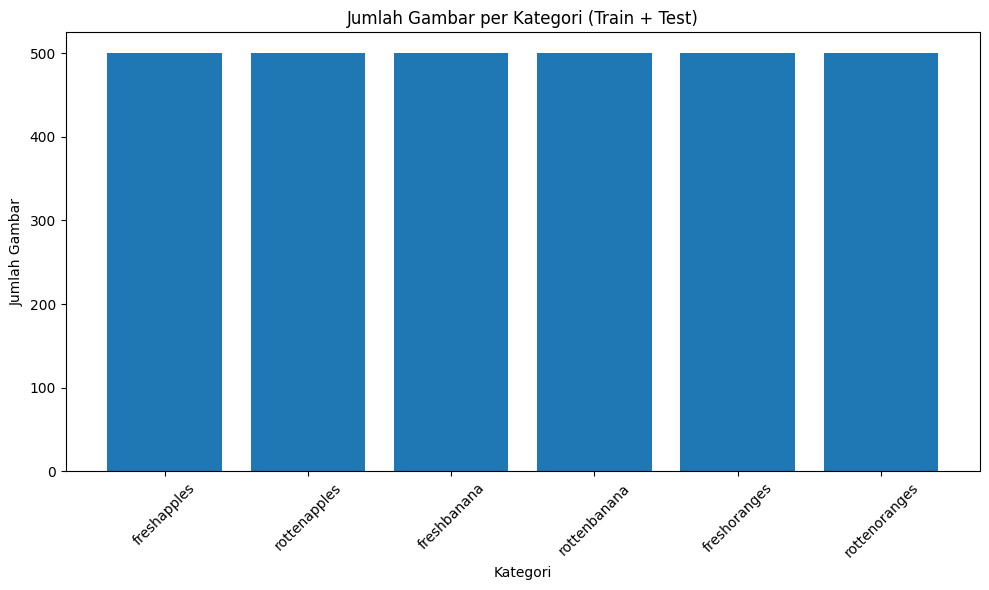

In [97]:
def count_data_for_plot(train_dir, test_dir, categories):
    labels = []
    counts = []
    for category in categories:
        train_paths = get_all_image_paths(os.path.join(train_dir, category))
        test_paths = get_all_image_paths(os.path.join(test_dir, category))
        total = len(train_paths) + len(test_paths)
        labels.append(category)
        counts.append(total)
    return labels, counts

# ==== Set Path dan Kategori ====
base_dir = r"datasets"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

fruit_types = ['apples', 'banana', 'oranges']
all_categories = []
for fruit in fruit_types:
    all_categories.extend([f"fresh{fruit}", f"rotten{fruit}"])

# ==== Hitung dan Plot ====
labels, counts = count_data_for_plot(train_dir, test_dir, all_categories)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.title("Jumlah Gambar per Kategori (Train + Test)")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Alur Program Klasifikasi Buah Segar dan Busuk**
Mengandalkan ekstraksi warna (hue) sebagai fitur pembeda kesegaran buah secara efektif.

1. Inisialisasi dan Struktur Data (Class FruitRipenessClassifier)
    - Menyimpan direktori data latih (train_dir) dan data uji (test_dir).
    - Membuat instance dari class Classifier untuk menyimpan kategori buah (categories) dan rentang hue-nya (hue_ranges).

2. Preprocessing Gambar (Class ImageProcessor)
    - Median Filter (Noise Reduction)
      - Menghilangkan noise menggunakan median filter berbasis padding reflektif.
      - Menghindari artefak di tepi gambar dengan teknik mirror padding.
    - Konversi RGB → HSV
      - Konversi manual dari RGB ke HSV.
      - Menghasilkan citra dengan 3 channel: Hue, Saturation, Value.
      - Hue digunakan sebagai fitur utama.


3. Ekstraksi Fitur Warna (Class FeatureExtractor)
    - Mengambil statistik channel Hue, baik secara keseluruhan maupun pada area dengan warna signifikan (S > 0.3 dan V > 0.3).
    - Fitur yang dihasilkan:
      - Rata-rata (mean), standar deviasi (std), dan median Hue.
      - Statistik Hue untuk area berwarna mencolok (significant_hue_mean, significant_hue_std).

4. Pelatihan Model (Class Classifier)
    - Untuk setiap kategori buah (misal: 'fresh', 'rotten'):
      - Memproses semua gambar dalam folder kategori.
      - Menghitung rata-rata dan standar deviasi hue dari area signifikan.
      - Menyimpan rentang hue kategori: mean ± 2*std → disimpan dalam self.hue_ranges.

6. Klasifikasi Gambar Uji (classify_image)
    - Preprocessing dan ekstraksi fitur pada gambar uji
    - Bandingkan hue dominan terhadap rentang hue kategori latih.

    - Hitung skor kemiripan berdasarkan:
      - Jarak hue (hue_distance)
      - Penalti jika distribusi hue tidak wajar (std_penalty)
      - Penalti jika hue dominan di luar rentang kategori (hue_penalty)

    Pilih kategori dengan total skor terkecil.

7. Evaluasi Model (evaluate)
    - Bandingkan prediksi terhadap label asli dari gambar uji.

8. Visualisasi Hasil

9. Mengembalikan nilai akurasi akhir dari model.

# **Definisi Kelas FruitRipenessClassifier**



In [ ]:

class ImageProcessor:
    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def median_filter(image, kernel_size=3):
        """Apply median filter to an image with reflection padding"""
        pad_size = kernel_size // 2
        h, w, c = image.shape
        output = np.zeros_like(image)
        
        # Manual padding with reflection
        padded_img = np.zeros((h + 2*pad_size, w + 2*pad_size, c), dtype=image.dtype)
        padded_img[pad_size:h+pad_size, pad_size:w+pad_size, :] = image
        
        # Reflect padding
        for i in range(pad_size):
            # Top and bottom borders
            padded_img[i, :, :] = padded_img[2*pad_size-i, :, :]
            padded_img[h+pad_size+i, :, :] = padded_img[h+pad_size-2-i, :, :]
        for j in range(pad_size):
            # Left and right borders
            padded_img[:, j, :] = padded_img[:, 2*pad_size-j, :]
            padded_img[:, w+pad_size+j, :] = padded_img[:, w+pad_size-2-j, :]
        
        # Pre-compute kernel area
        k_area = kernel_size * kernel_size
        mid_pos = k_area // 2
        
        # Process each channel in parallel
        for ch in numba.prange(c):
            for i in range(h):
                for j in range(w):
                    # Extract patch
                    patch = padded_img[i:i+kernel_size, j:j+kernel_size, ch]
                    
                    # Flatten and find median without full sort
                    flat_patch = patch.ravel()
                    
                    # Partial sort just to find median
                    if k_area % 2 == 1:
                        # For odd-sized kernels, just find the middle element
                        for k in range(mid_pos + 1):
                            min_idx = k
                            for m in range(k + 1, k_area):
                                if flat_patch[m] < flat_patch[min_idx]:
                                    min_idx = m
                            if min_idx != k:
                                flat_patch[k], flat_patch[min_idx] = flat_patch[min_idx], flat_patch[k]
                        output[i, j, ch] = flat_patch[mid_pos]
                    else:
                        # For even-sized kernels, find two middle elements
                        for k in range(mid_pos + 1):
                            min_idx = k
                            for m in range(k + 1, k_area):
                                if flat_patch[m] < flat_patch[min_idx]:
                                    min_idx = m
                            if min_idx != k:
                                flat_patch[k], flat_patch[min_idx] = flat_patch[min_idx], flat_patch[k]
                        output[i, j, ch] = (flat_patch[mid_pos-1] + flat_patch[mid_pos]) / 2
        
        return output

    @staticmethod
    def rgb_to_hsv(rgb_img):
        """Convert RGB image to HSV color space manually"""
        # Normalize RGB values to [0, 1] range
        rgb_norm = rgb_img.astype(np.float32) / 255.0
        r, g, b = rgb_norm[:, :, 0], rgb_norm[:, :, 1], rgb_norm[:, :, 2]

        # Value (V) is the maximum of R, G, B
        v = np.max(rgb_norm, axis=2)

        # Delta is the difference between max and min of R, G, B
        min_rgb = np.min(rgb_norm, axis=2)
        delta = v - min_rgb

        # Initialize Saturation (S) with zeros
        s = np.zeros_like(v)
        non_zero_v_mask = v != 0
        s[non_zero_v_mask] = delta[non_zero_v_mask] / v[non_zero_v_mask]

        # Initialize Hue (H) with zeros
        h = np.zeros_like(v)
        non_zero_delta_mask = delta != 0

        # Masks for determining dominant color
        red_max_mask = (v == r) & non_zero_delta_mask
        green_max_mask = (v == g) & non_zero_delta_mask
        blue_max_mask = (v == b) & non_zero_delta_mask

        # Calculate Hue based on dominant channel
        h[red_max_mask] = ((g[red_max_mask] - b[red_max_mask]) / delta[red_max_mask]) % 6
        h[green_max_mask] = 2 + (b[green_max_mask] - r[green_max_mask]) / delta[green_max_mask]
        h[blue_max_mask] = 4 + (r[blue_max_mask] - g[blue_max_mask]) / delta[blue_max_mask]

        # Convert H from degrees to [0, 1] range
        h = h * 60         # From 0-6 to 0-360 degrees
        h[h < 0] += 360    # Ensure positive values
        h = h / 360.0      # Scale to [0, 1] range

        return np.stack([h, s, v], axis=2)

    @staticmethod
    def preprocess_image(image_path):
        """Load and preprocess an image"""
        img = cv2.imread(image_path)
        if img is None:
            print(f"[WARNING] Could not read image: {image_path}")
            return None
        img = img[:, :, ::-1]  # Convert BGR to RGB
        img = ImageProcessor.median_filter(img, kernel_size=5)
        return img

class FeatureExtractor:
    @staticmethod
    def extract_features(preprocessed_img):
        """Extract color features from preprocessed image"""
        hsv_img = ImageProcessor.rgb_to_hsv(preprocessed_img)
        hue_channel = hsv_img[:, :, 0]
        s_channel = hsv_img[:, :, 1]
        v_channel = hsv_img[:, :, 2]
        
        # Create mask for significant color areas
        mask = (s_channel > 0.3) & (v_channel > 0.3)
        masked_hue = hue_channel[mask]
        if len(masked_hue) == 0:
            masked_hue = hue_channel.flatten()

        return {
            'hue_mean': np.mean(hue_channel),
            'hue_std': np.std(hue_channel),
            'hue_median': np.median(hue_channel),
            'significant_hue_mean': np.mean(masked_hue),
            'significant_hue_std': np.std(masked_hue),
            'hsv_img': hsv_img
        }

class Classifier:
    def __init__(self):
        self.categories = []
        self.hue_ranges = {}

    def train(self, train_dir):
        """Train classifier on images in train_dir"""
        print("Training the classifier...")
        for category in self.categories:
            print(f"Processing category: {category}")
            category_features = []
            image_paths = get_all_image_paths(os.path.join(train_dir, category))
            for img_path in image_paths:
                preprocessed_img = ImageProcessor.preprocess_image(img_path)
                if preprocessed_img is not None:
                    features = FeatureExtractor.extract_features(preprocessed_img)
                    category_features.append(features)
            
            if len(category_features) > 0:
                hue_means = [f['significant_hue_mean'] for f in category_features]
                hue_stds = [f['significant_hue_std'] for f in category_features]
                avg_hue_mean = np.mean(hue_means)
                avg_hue_std = np.mean(hue_stds)
                
                self.hue_ranges[category] = {
                    'min': max(0, avg_hue_mean - 2 * avg_hue_std),
                    'max': min(1, avg_hue_mean + 2 * avg_hue_std),
                    'mean': avg_hue_mean,
                    'std': avg_hue_std
                }
                print(f"  {category} - Hue range: {self.hue_ranges[category]['min']:.3f} to {self.hue_ranges[category]['max']:.3f}")
            else:
                print(f"[WARNING] No training data for category: {category}")
        print("Training completed.")

    def classify_image(self, image_path):
        """Classify a single image based on trained hue ranges"""
        preprocessed_img = ImageProcessor.preprocess_image(image_path)
        if preprocessed_img is None:
            return None, None
            
        features = FeatureExtractor.extract_features(preprocessed_img)
        best_match = None
        min_distance = float('inf')
        
        for category, hue_range in self.hue_ranges.items():
            hue_mean = features['significant_hue_mean']
            hue_std = features['significant_hue_std']
            hue_data = features['hsv_img'][:, :, 0]
            s_channel = features['hsv_img'][:, :, 1]
            v_channel = features['hsv_img'][:, :, 2]
            mask = (s_channel > 0.3) & (v_channel > 0.3)
            masked_hue = hue_data[mask]

            hist, bins = np.histogram(masked_hue, bins=50, range=(0, 1))
            most_freq_hue_bin_idx = np.argmax(hist)
            bin_center = (bins[most_freq_hue_bin_idx] + bins[most_freq_hue_bin_idx + 1]) / 2

            hue_distance = abs(hue_mean - hue_range['mean'])
            std_threshold = 0.05
            std_penalty = 0.1 if (('rotten' in category and hue_std < std_threshold) or
                                  ('fresh' in category and hue_std > std_threshold)) else 0.0
            hue_penalty = 0.1 if not (hue_range['min'] <= bin_center <= hue_range['max']) else 0.0
            total_score = hue_distance + std_penalty + hue_penalty

            if total_score < min_distance:
                min_distance = total_score
                best_match = category

        return best_match, features

class FruitRipenessClassifier:
    def __init__(self, train_dir, test_dir):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.classifier = Classifier()
        self.classifier.categories = []  

    def evaluate(self):
        """Evaluate classifier performance on test set"""
        print("Evaluating the classifier...")
        true_labels = []
        pred_labels = []
        
        for category in self.classifier.categories:
            print(f"Testing category: {category}")
            image_paths = get_all_image_paths(os.path.join(self.test_dir, category))
            for img_path in image_paths:
                predicted_class, _ = self.classifier.classify_image(img_path)
                if predicted_class is not None:
                    true_labels.append(category)
                    pred_labels.append(predicted_class)
                    
        if len(true_labels) == 0:
            print("[ERROR] No valid test data found.")
            return 0.0, np.zeros((len(self.classifier.categories), len(self.classifier.categories)))
            
        accuracy = accuracy_score(true_labels, pred_labels)
        print(f"Overall Accuracy: {accuracy:.4f}")
        cm = confusion_matrix(true_labels, pred_labels, labels=self.classifier.categories)
        return accuracy, cm

    def visualize_results(self, num_samples=2, fruit_name="fruit"):
        """Visualize classification results with sample images"""
        fig = plt.figure(figsize=(15, 20))
        fig.suptitle(f'Fruit Ripeness Classification Results - {fruit_name.capitalize()}', fontsize=16)
        sample_idx = 1
        
        for category in self.classifier.categories:
            image_paths = get_all_image_paths(os.path.join(self.test_dir, category))[:num_samples]
            for img_path in image_paths:
                preprocessed_img = ImageProcessor.preprocess_image(img_path)
                if preprocessed_img is None:
                    continue
                    
                predicted_class, features = self.classifier.classify_image(img_path)
                if predicted_class and features:
                    ax1 = fig.add_subplot(len(self.classifier.categories), num_samples * 3, sample_idx)
                    ax1.imshow(preprocessed_img)
                    ax1.set_title(f"Original\nTrue: {category}")
                    ax1.axis('off')
                    
                    ax2 = fig.add_subplot(len(self.classifier.categories), num_samples * 3, sample_idx + 1)
                    ax2.imshow(features['hsv_img'][:, :, 0], cmap='hsv')
                    ax2.set_title(f"Hue\nPred: {predicted_class}")
                    ax2.axis('off')
                    
                    ax3 = fig.add_subplot(len(self.classifier.categories), num_samples * 3, sample_idx + 2)
                    ax3.imshow(hsv_to_rgb(features['hsv_img']))
                    ax3.set_title(f"HSV\nH_mean: {features['significant_hue_mean']:.3f}")
                    ax3.axis('off')
                    
                    sample_idx += 3
                    
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig(f'classification_results_{fruit_name}.png', dpi=300)
        plt.show()

    def visualize_confusion_matrix(self, cm, fruit_name="fruit"):
        """Visualize confusion matrix"""
        if np.sum(cm) == 0:
            print(f"[SKIPPED] Empty confusion matrix for {fruit_name}")
            return
            
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                   xticklabels=self.classifier.categories, 
                   yticklabels=self.classifier.categories)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {fruit_name.capitalize()}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{fruit_name}.png', dpi=300)
        plt.show()

    def run(self, fruit_name="fruit"):
        """Run the complete pipeline: train → evaluate → visualize"""
        self.classifier.train(self.train_dir)
        accuracy, cm = self.evaluate()
        
        if np.sum(cm) > 0:
            self.visualize_results(fruit_name=fruit_name)
            self.visualize_confusion_matrix(cm, fruit_name=fruit_name)
            
        return accuracy


==== Processing APPLES ====

Training the classifier...
Processing category: freshapples
  freshapples - Hue range: 0.000 to 0.690
Processing category: rottenapples
  rottenapples - Hue range: 0.000 to 0.257
Training completed.
Evaluating the classifier...
Testing category: freshapples
Testing category: rottenapples
Overall Accuracy: 0.8250


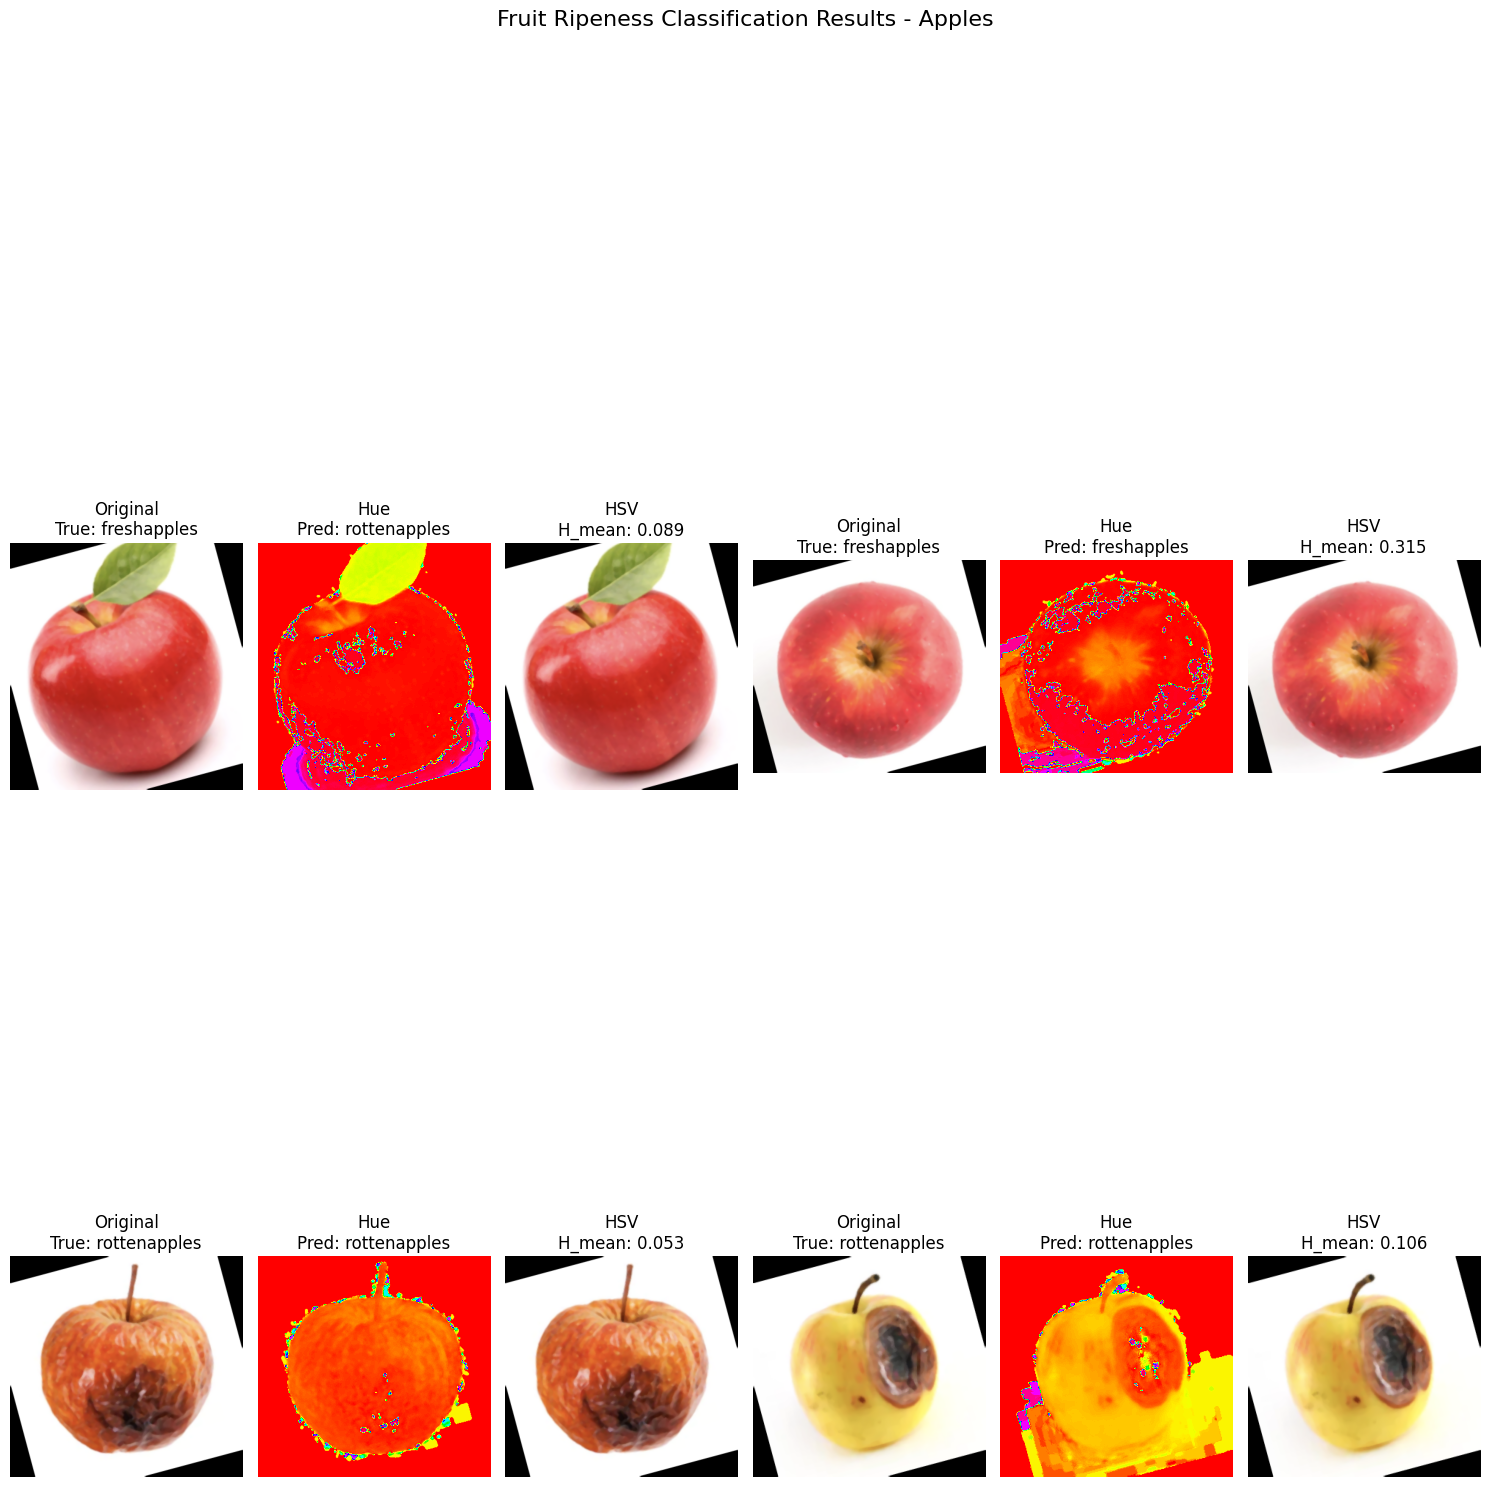

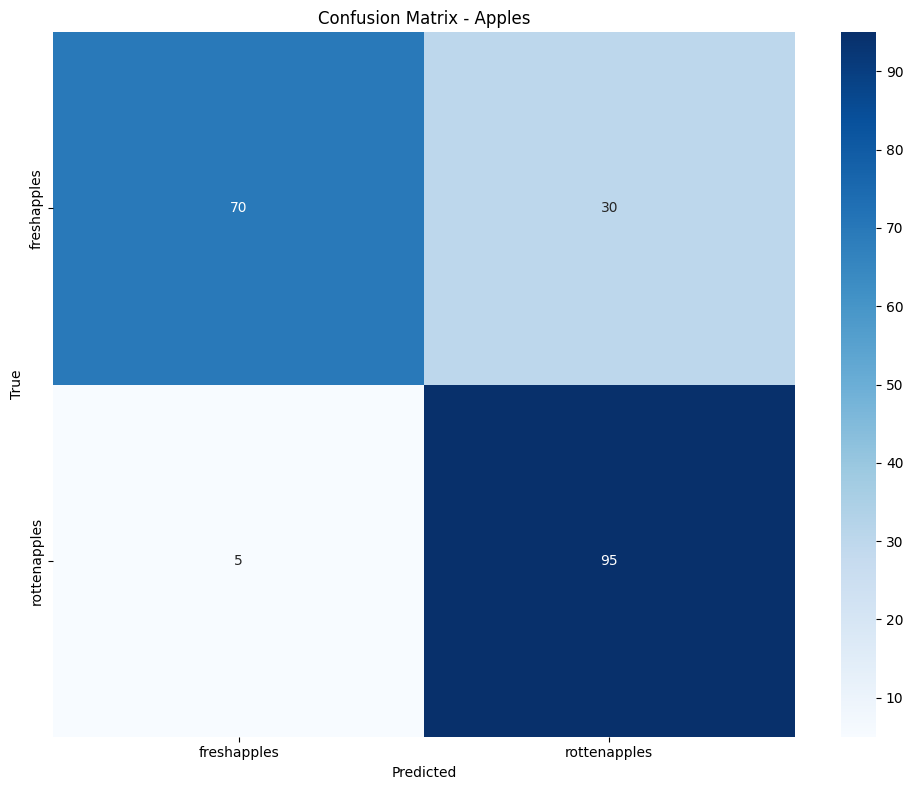


Apples classification completed with accuracy: 0.8250

==== Processing BANANA ====

Training the classifier...
Processing category: freshbanana
  freshbanana - Hue range: 0.097 to 0.170
Processing category: rottenbanana
  rottenbanana - Hue range: 0.000 to 0.237
Training completed.
Evaluating the classifier...
Testing category: freshbanana
Testing category: rottenbanana
Overall Accuracy: 0.8800


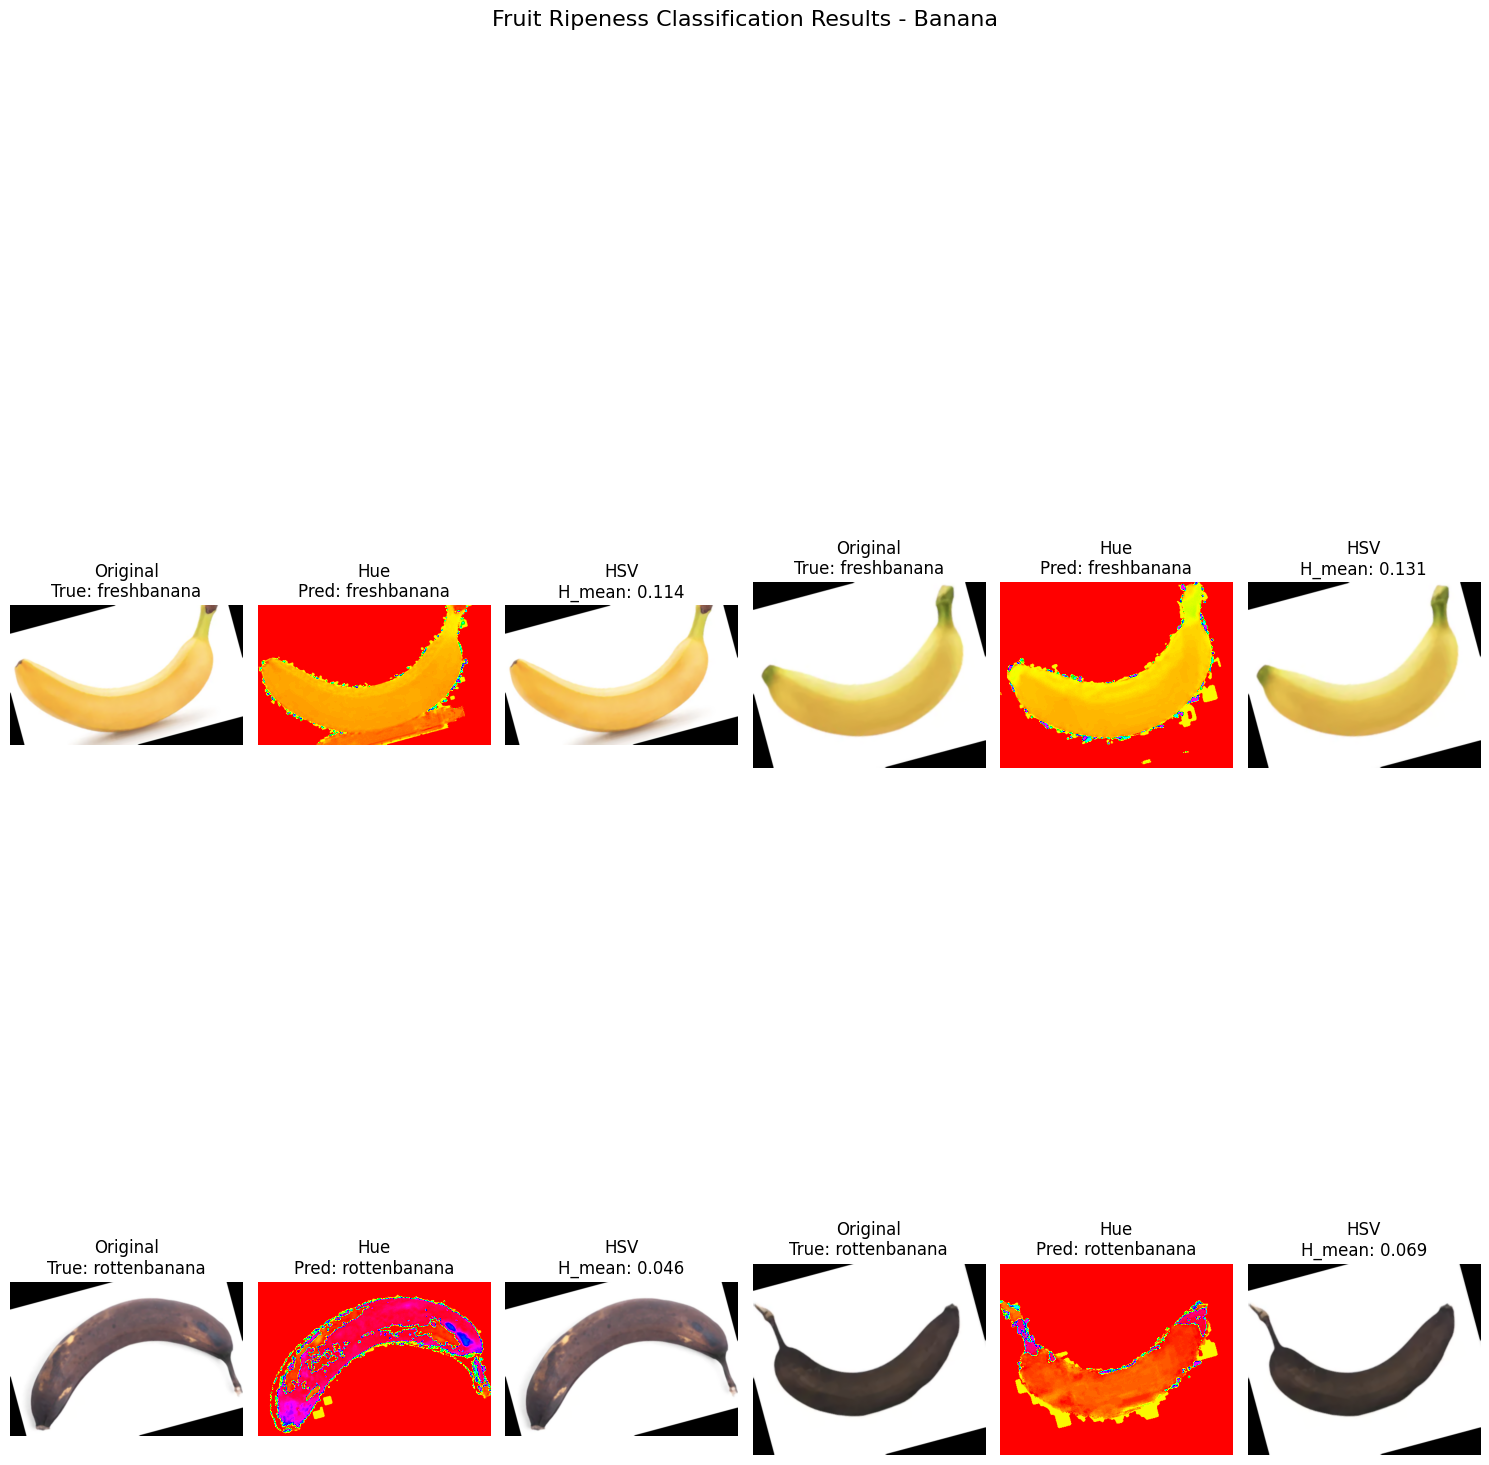

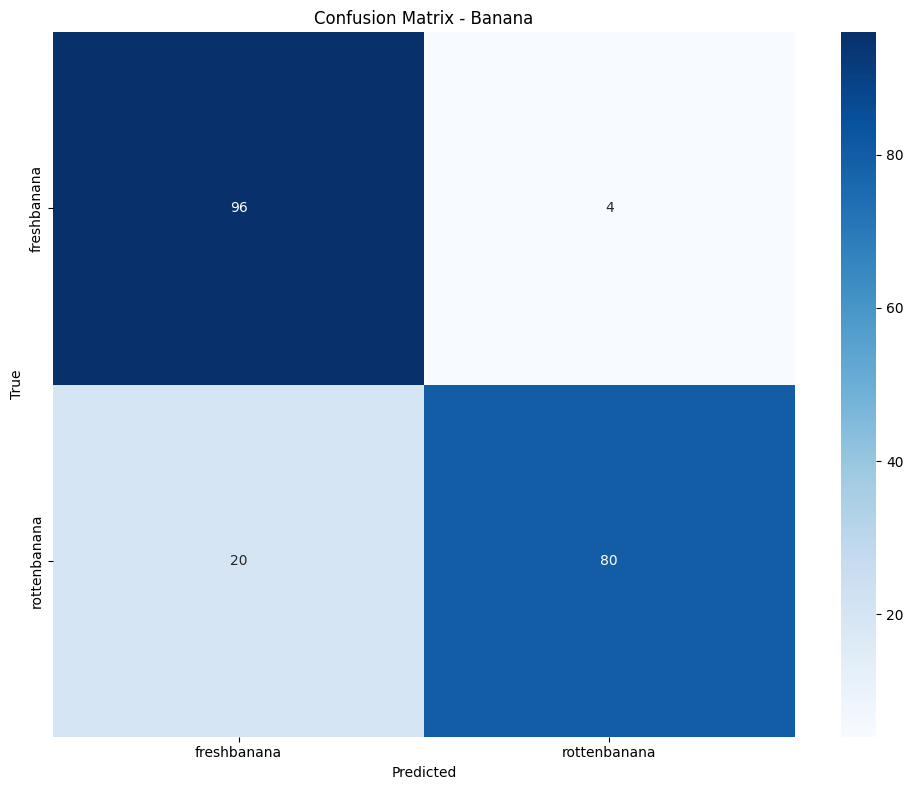


Banana classification completed with accuracy: 0.8800

==== Processing ORANGES ====

Training the classifier...
Processing category: freshoranges
  freshoranges - Hue range: 0.009 to 0.174
Processing category: rottenoranges
  rottenoranges - Hue range: 0.010 to 0.154
Training completed.
Evaluating the classifier...
Testing category: freshoranges
Testing category: rottenoranges
Overall Accuracy: 0.4300


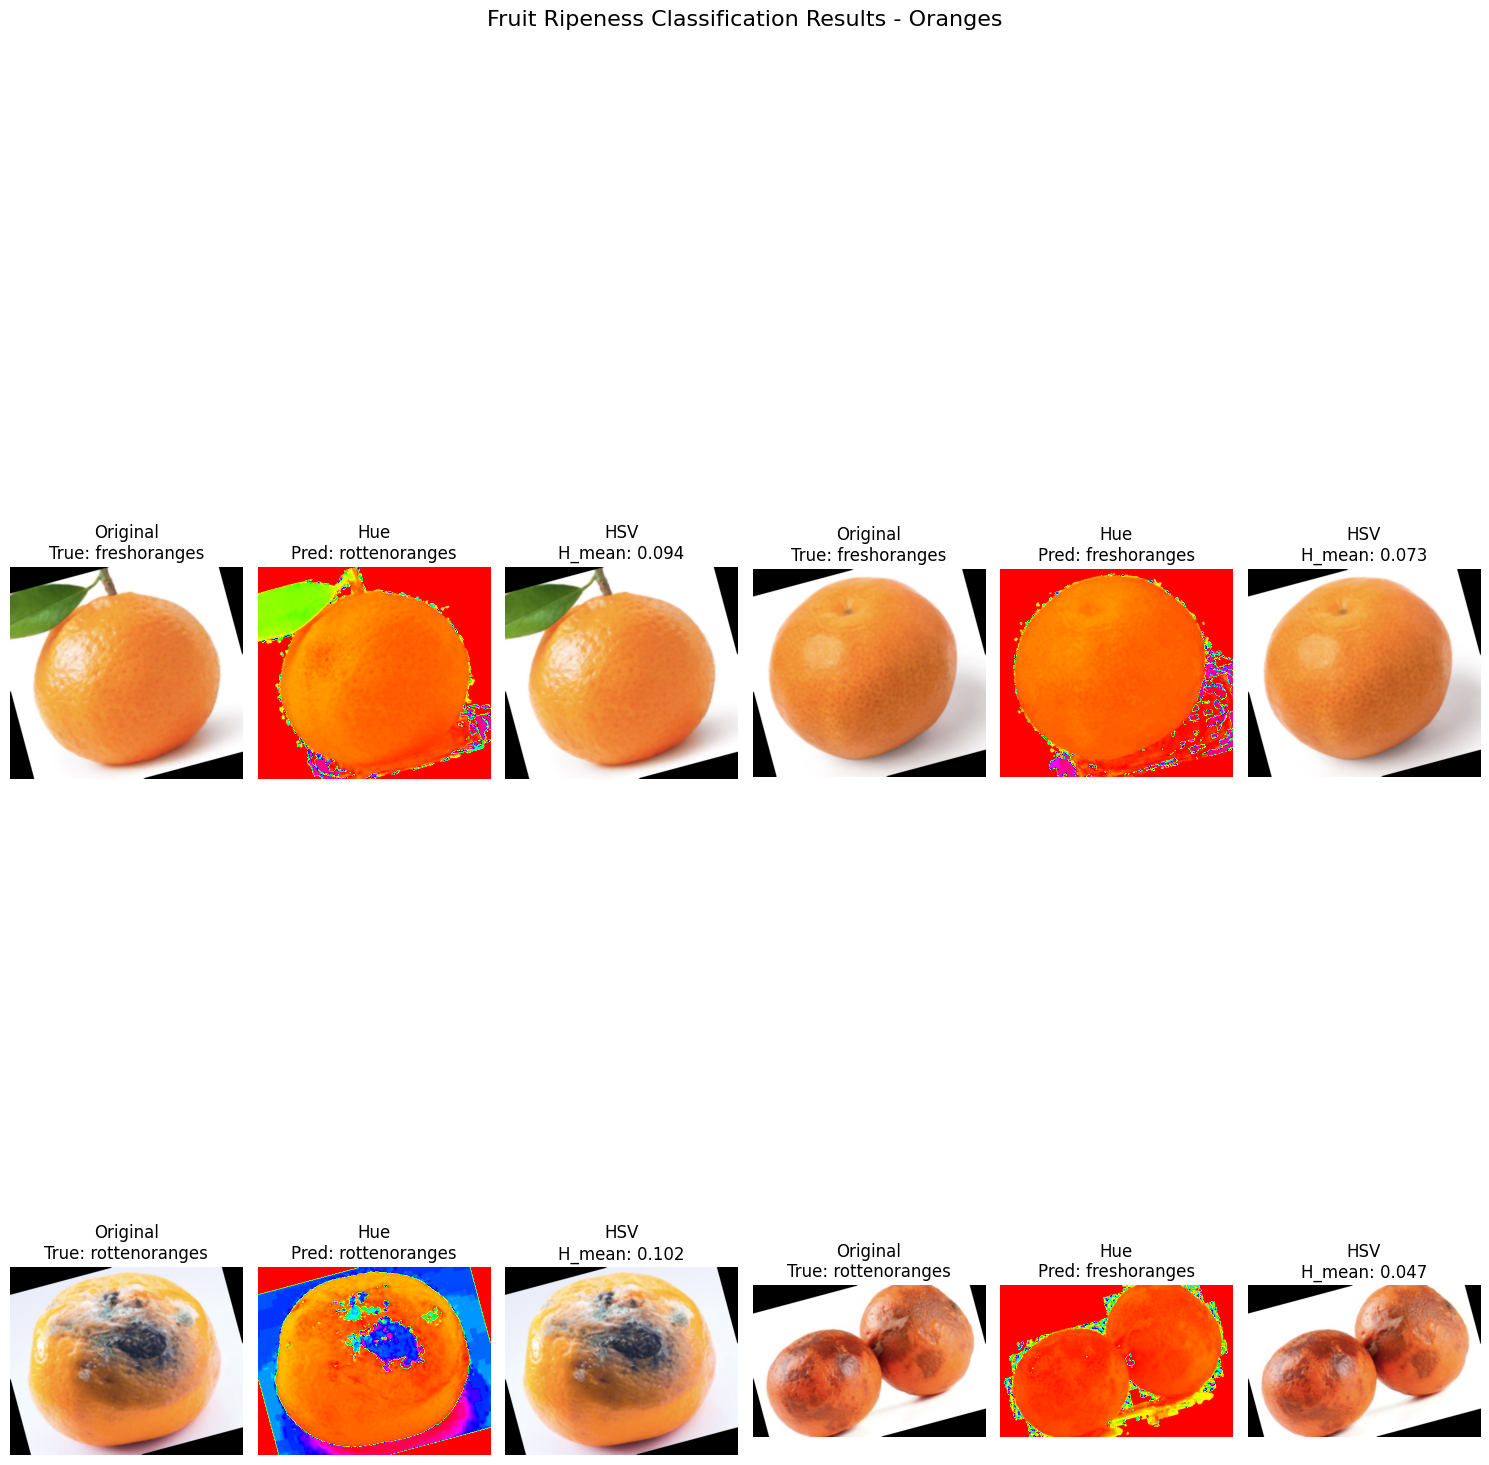

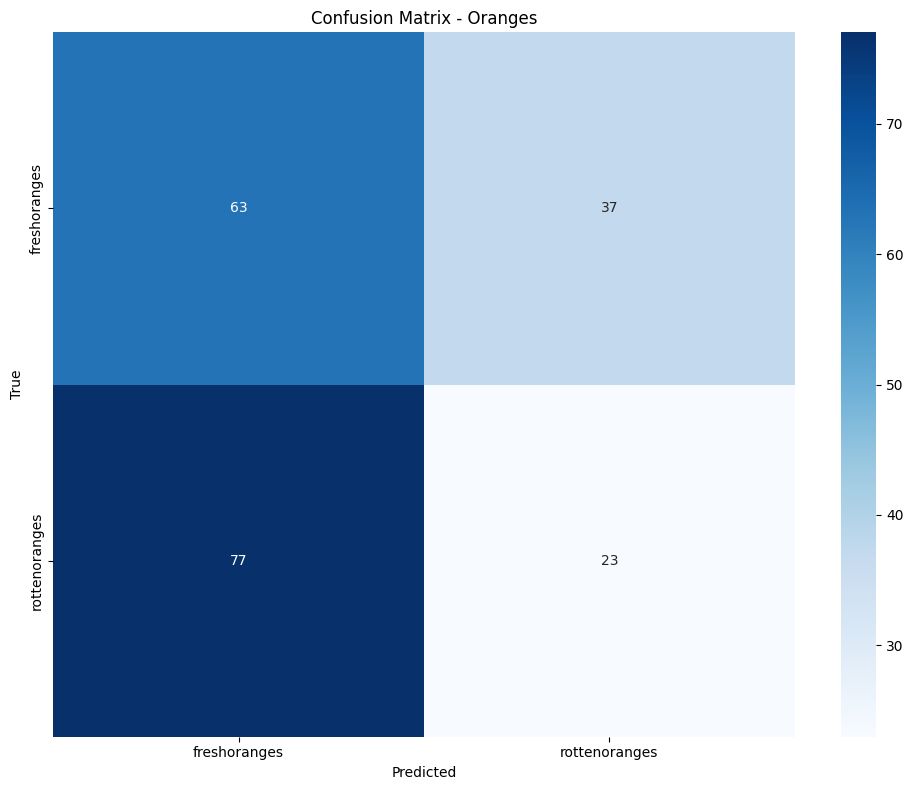


Oranges classification completed with accuracy: 0.4300

=== FINAL ACCURACY SUMMARY ===
Apples : 0.8250 (82.50%)
Banana : 0.8800 (88.00%)
Oranges: 0.4300 (43.00%)


In [99]:
if __name__ == "__main__":
    base_dir = r"datasets"
    train_dir = os.path.join(base_dir, "train")
    test_dir = os.path.join(base_dir, "test")

    fruit_types = ['apples', 'banana', 'oranges'] 
    final_results = {}

    for fruit in fruit_types:
        print(f"\n{'='*30}")
        print(f"==== Processing {fruit.upper()} ====")
        print(f"{'='*30}\n")
        
        # Categories without underscore
        categories = [f"fresh{fruit}", f"rotten{fruit}"]
        
        classifier = FruitRipenessClassifier(train_dir, test_dir)
        classifier.classifier.categories = categories
        
        accuracy = classifier.run(fruit_name=fruit)
        final_results[fruit] = accuracy
        
        print(f"\n{fruit.capitalize()} classification completed with accuracy: {accuracy:.4f}")

    # Print final summary
    print("\n" + "="*30)
    print("=== FINAL ACCURACY SUMMARY ===")
    print("="*30)
    max_name_length = max(len(fruit) for fruit in final_results.keys())
    
    for fruit, acc in final_results.items():
        print(f"{fruit.capitalize().ljust(max_name_length)}: {acc:.4f} ({acc*100:.2f}%)")
    

# **Evaluasi** 

**Apel**

freshapples: hue range = 0.000 – 0.690
rottenapples: hue range = 0.000 – 0.257

Rentang nilai hue pada apel segar jauh lebih lebar dibandingkan apel busuk, menunjukkan keragaman warna yang lebih tinggi pada apel segar. Sementara itu, apel busuk memiliki rentang hue yang lebih sempit dan lebih rendah, mencerminkan penurunan kualitas warna akibat pembusukan.
- Model berhasil memprediksi sebagian besar gambar dengan benar. Contoh prediksi benar termasuk apel segar dengan H_mean yang berada dalam kisaran 0.3–0.6.
- Namun, terdapat kesalahan prediksi, terutama pada apel segar yang memiliki nilai hue rendah (misalnya H_mean ≈ 0.057), sehingga diklasifikasikan sebagai busuk karena mendekati distribusi hue apel busuk.
- Apel busuk berhasil dikenali dengan baik, terutama yang memiliki hue rendah dan konsisten, seperti H_mean ≈ 0.036 atau 0.162.

Akurasi keseluruhan: 82.50%

Model cukup efektif dalam membedakan apel segar dan busuk hanya berdasarkan karakteristik warna (hue), meskipun rentang tumpang tindih kecil pada bagian bawah menyebabkan sedikit ambiguitas.

**Pisang**

freshbanana: hue range = 0.097 – 0.170
rottenbanana: hue range = 0.000 – 0.237

Rentang hue pisang segar relatif sempit dan berada di kisaran menengah, sedangkan pisang busuk menunjukkan variasi hue yang lebih luas—mulai dari sangat rendah (hampir hitam/cokelat) hingga cukup tinggi—menunjukkan perubahan warna signifikan saat pembusukan terjadi.

- Model sangat baik dalam mengklasifikasikan pisang segar, karena distribusi hue yang konsisten dan tidak tumpang tindih terlalu banyak dengan pisang busuk.
- Kesalahan minimal terjadi karena model mampu mengenali batas bawah hue segar dan membedakannya dari nilai ekstrim pada pisang busuk.
- Pisang busuk dengan hue mendekati 0 diklasifikasikan secara akurat karena kontras warnanya tinggi terhadap pisang segar.

Akurasi keseluruhan: 88.00%

Model sangat andal dalam mengenali kondisi pisang berdasarkan warna. Rentang hue yang berbeda jelas antara segar dan busuk membuat klasifikasi relatif mudah dan efektif.


**Jeruk**

freshoranges: hue range = 0.009 – 0.174
rottenoranges: hue range = 0.010 – 0.154

Distribusi hue pada jeruk segar dan busuk sangat tumpang tindih, dengan perbedaan rentang yang sangat kecil. Hal ini menyebabkan tantangan besar bagi model dalam membedakan keduanya hanya berdasarkan hue.

- Banyak kesalahan klasifikasi terjadi karena tidak ada pemisahan hue yang jelas antara jeruk segar dan busuk.
- Jeruk segar dan busuk bisa memiliki H_mean serupa, membuat model kesulitan dalam menentukan kelas yang tepat.
- Contoh jeruk busuk yang memiliki H_mean tinggi dapat diklasifikasikan keliru sebagai segar, dan sebaliknya.

Akurasi keseluruhan: 43.00%

Model tidak efektif untuk buah ini jika hanya mengandalkan informasi warna. Rentang hue yang hampir identik antara jeruk segar dan busuk menyebabkan klasifikasi sangat tidak akurat. Pendekatan tambahan seperti tekstur atau fitur lain mungkin dibutuhkan.

# **Kesimpulan**

Penelitian ini mengembangkan dan mengimplementasikan sistem klasifikasi tingkat kematangan buah menggunakan metode ekstraksi warna berbasis ruang warna HSV, dengan fokus pada komponen Hue (H) sebagai fitur utama.

Hasil klasifikasi menunjukkan bahwa:

🍎 Apel berhasil diklasifikasikan dengan akurasi 82.50%.
Perbedaan rentang hue antara apel segar dan busuk cukup signifikan, memungkinkan model membedakan keduanya secara efektif berdasarkan distribusi warna dominan. Meskipun terdapat sedikit tumpang tindih di bagian bawah rentang hue, model tetap menunjukkan performa yang baik.

🍌 Pisang menghasilkan akurasi tinggi sebesar 88.00%.
Perubahan warna kulit pisang dari kuning cerah menjadi coklat tua saat membusuk menyebabkan distribusi hue sangat berbeda antara kondisi segar dan busuk. Hal ini menjadikan hue sebagai indikator yang sangat kuat dalam proses klasifikasi.

🍊 Jeruk mengalami penurunan performa dengan akurasi hanya 43.00%.
Penurunan ini disebabkan oleh dua faktor utama:
- Rentang hue antara jeruk segar dan busuk sangat tumpang tindih, karena warna kulit jeruk tidak mengalami perubahan mencolok secara visual meskipun telah membusuk.
- Kemungkinan distribusi data jeruk busuk yang terlalu beragam, karena jeruk busuk ada berbagai macam warna, seperti busuk abu, hitam, hijau dan lain-lain, sehingga mengecohkan hasil ekstrasi warna (hue)